In [1]:
### Trying to make a gibbs sampler: 

# My idea is to add individual specific data, in a fast and easy to adapt way. 
#it seems to be working now, but it certainly have trouble with autocorrelation

# I Think even if I was to make it to work It would require some clever thinking in how to deal
#with unequal number of choice situations over the individuals

# Constructing synthetic data

In [312]:
from numpy.random import normal
import numpy as np
np.random.seed(0)
rng = np.random.RandomState(10)
import scipy.stats
import math
import collections
import pandas as pd
from tqdm import tqdm, tqdm_notebook

In [313]:
# Random alternative specific coefficients: 
N = 696
J = 10  # alternatives
T = 10 # Choice situations
K = 2 # variables

mean = np.zeros((N,T,J,K))
variance = np.identity(K)*2 
X = normal(mean, 1)

X.shape # N*T*J*K

## Simulating som mixed logit data:
# U = deterministic part + random part


# Random coefficients
# Coefficients drawn from a normal: 
# Priors
b = normal(0,1,K)
b_true_coeff = b


B = np.identity(K)*1 #+ np.diag((2,1))


U = np.zeros((N,T,J))

#coeff=np.random.multivariate_normal(b,B, size = N) 
coeff=rng.multivariate_normal(b,B, size = N) 




b_true = np.mean(coeff, axis = 0)
B_true=np.cov(coeff,rowvar=False)



print(b_true)
print(b)
print(B_true)
gumb = rng.gumbel(size = (N,T,J))
print(gumb.shape)
for n in range(N): 
    for t in range(T):
        U_n=X[n,t,:].dot(coeff[n,:].T) + gumb[n,t,:]
        U[n,t,:] = U_n

Y = np.argmax(U,axis = 2)
# Making a baseline category: U < 0 
#base_choices=np.argwhere(np.max(U,axis=2) < 0)
#Y[base_choices] = J

unique, counts = np.unique(Y, return_counts=True)
counts


[-2.4584061  -0.70720137]
[-2.44934455 -0.70329575]
[[ 0.94973965 -0.00853747]
 [-0.00853747  0.86934546]]
(696, 10, 10)


array([731, 731, 639, 687, 644, 720, 703, 684, 698, 723])

In [314]:
X.shape # N*T*J*K I will reshape this into a NTJ*1
X_t = X.reshape((N*T*J,K))
user = np.repeat(range(N),T*J) # I make an index that is supposed to look as if a user index existed
Y_t = Y.reshape(N*T)
Y_tt = Y_t.repeat(J)
#beta_N.shape
Y_tt 
index=np.tile(range(J),N*T)
y_index=np.where(np.equal(Y_tt,index).astype(int))[0]

mask = np.ones(index.size, dtype=bool)
mask[y_index] = 0
y_nindex = np.where(mask)[0]
y_nindex

np.array([user,index]).T
list_users=user[y_index]
users=list(collections.Counter(user).values())
NT = N*T


In [315]:
X_t=X_t.astype(float)
count_users = np.cumsum(np.unique(list_users, return_counts=True)[1])
count_users

array([  10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  110,
        120,  130,  140,  150,  160,  170,  180,  190,  200,  210,  220,
        230,  240,  250,  260,  270,  280,  290,  300,  310,  320,  330,
        340,  350,  360,  370,  380,  390,  400,  410,  420,  430,  440,
        450,  460,  470,  480,  490,  500,  510,  520,  530,  540,  550,
        560,  570,  580,  590,  600,  610,  620,  630,  640,  650,  660,
        670,  680,  690,  700,  710,  720,  730,  740,  750,  760,  770,
        780,  790,  800,  810,  820,  830,  840,  850,  860,  870,  880,
        890,  900,  910,  920,  930,  940,  950,  960,  970,  980,  990,
       1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100,
       1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210,
       1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320,
       1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430,
       1440, 1450, 1460, 1470, 1480, 1490, 1500, 15

In [316]:
beta_N = np.ones((696,5))*0.01

In [317]:
#benchmark:
B = np.array([2,3,4,5,6,7,8,9])
A = np.array([1,1,1,2,3,4,6,6])
A_u, A_c=np.unique(A,return_counts = True)
def reshape(A_u,A_c, B):
    k = 0
    p= np.ones((A_u.size,np.max(A_c)))
    for i in range(A_u.size):
        for j in range(np.max(A_c[i])):
            if j < A_c[i]:
                p[i,j] = B[k]
                k += 1
    return p
p = reshape(A_u, A_c,B)
p

array([[2., 3., 4.],
       [5., 1., 1.],
       [6., 1., 1.],
       [7., 1., 1.],
       [8., 9., 1.]])

In [318]:
#adaption
def reshape(A_u,A_c, B):
    k = 0
    t = 0
    put_list = []
    set_list = []
    p= np.ones((A_u.size,np.max(A_c)))
    for i in range(A_u.size):
        for j in range(np.max(A_c)):
            if j <= A_c[i]-1:
                #p[i,j] = B[k]
                set_list.append(t)
                k += 1
            t += 1
    return set_list

set_t = reshape(A_u,A_c,B)
k = np.ones(3*5)   
k
set_t
A
#set_t
np.put(k , set_t, B )
k.reshape(5,3)


array([[2., 3., 4.],
       [5., 1., 1.],
       [6., 1., 1.],
       [7., 1., 1.],
       [8., 9., 1.]])

In [319]:
A_u, A_c=np.unique(list_users,return_counts = True)
def reshape(A_u,A_c):
    k = 0
    t = 0
    put_list = []
    set_list = []
    p= np.ones((A_u.size,np.max(A_c)))
    for i in range(A_u.size):
        for j in range(np.max(A_c)):
            if j <= A_c[i]-1:
                #p[i,j] = B[k]
                set_list.append(t)
                k += 1
            t += 1
    return set_list, np.max(A_c)

index, t_max = reshape(A_u,A_c)

def softmax_likelihood_v5(data, y_index, y_nindex, beta, users, N, NT, J, t_max, index):
    # construct N*T*K betas by repeating betas
    betas = np.repeat(beta, users, axis = 0)
    mu = np.exp(np.einsum('nj,nj->n',data,betas))
    denom = mu[y_index] # NT 
        
    # I'm worried the num is not returning correct values.
    num = np.sum(mu[y_nindex].reshape(NT,J-1),axis=1) + denom # NT*J -> NT
    sm_scores = denom / num
    # alternative approach: 
    test = np.ones(N*t_max)
    np.put(test, index, sm_scores)
    test = test.reshape((N,t_max))
    test = np.prod(test, axis= 1)
    return test

#test1 = softmax_likelihood_v5(X_t, y_index, y_nindex, beta_N, users, N, NT, J, t_max, index)

In [320]:
    def softmax_likelihood_v4(data, y_index, y_nindex, beta, list_users, count_users, users, NT,J):
        # construct N*T*K betas by repeating betas
        betas = np.repeat(beta, users, axis = 0)
        mu = np.exp(np.einsum('nj,nj->n',data,betas))
        denom = mu[y_index] # NT 
        
        # I'm worried the num is not returning correct values.
        num = np.sum(mu[y_nindex].reshape(NT,J-1),axis=1) + denom # NT*J -> NT
        sm_scores = denom / num
        
        test = np.split(sm_scores, count_users[:-1])
        test = [np.prod(test[i]) for i in range(len(test))]
        return np.array(test)
#test= softmax_likelihood_v4(X_t, y_index, y_nindex, beta_N, list_users,count_users, users, NT, J)

In [321]:
np.equal(test,test1).sum()

NameError: name 'test' is not defined

In [ ]:
    def density_pdf(mean, cov, beta):
        return scipy.stats.multivariate_normal(mean, cov).pdf(beta)

In [322]:
def metropolis_step_v3(data, y_index, y_nindex, beta_0, b, W, rho, users, N, NT, J, t_max, index):
    K=beta_N.shape[1]
    N=beta_N.shape[0]
    L = np.linalg.cholesky(W) # Cholesky factor of W
    eta = normal(0,1,(N,K)) #stacked vector of standard normal draws
    #print(eta.shape)
    #print(beta_N.shape)
    
    # trial value:
    beta_1_proposal = beta_0 + rho*eta.dot(L)

    # Draw a standard uniform variable: 
    threshold = np.random.uniform(0,1,N)

    # Calculate ratio:
    #data, y_index, y_nindex, beta, users, N, NT, J, t_max, index
    F1 = softmax_likelihood_v5(data, y_index, y_nindex, beta_1_proposal, users, N, NT,J, t_max, index)*density_pdf(b, W, beta_1_proposal)
    F0 = softmax_likelihood_v5(data, y_index, y_nindex, beta_0, users, N, NT,J, t_max, index)*density_pdf(b, W, beta_0)
    F = F1/F0
    
    # accept/reject
    
    cond = np.where(threshold<F,1,0)#beta_0[],beta_1_proposal[:])
    #acc_rate= np.sum(cond) / len(cond)
    acc_rate= np.sum(cond) / cond.size

    beta_1 = np.array([ b1 if c == 1 else b0 for b1,b0,c in zip(beta_1_proposal, beta_0, cond) ])
    
    return beta_1, acc_rate

#metropolis_step_v3(X_t, y_index, y_nindex, beta_N, b, W, rho, users, N,NT, J,t_max, index)

ValueError: shapes (696,5) and (2,2) not aligned: 5 (dim 1) != 2 (dim 0)

In [323]:
def softmax_likelihood(data, y_index, beta):
        # Would be a good idea to build some dimension checks
        mu = np.exp(data.dot(beta.T)).T
        N = mu.shape[0]
        sm_scores = mu / np.sum(mu, axis = 1)[:,None]
        denom = np.array([sm_scores[i,y_index[i]] for i in range(N) ])   
        
        return np.prod(denom, axis = 1 )
    
#test=softmax_likelihood(X,Y, beta_N)

def density_pdf(mean, cov, beta):
    return scipy.stats.multivariate_normal(mean, cov).pdf(beta)



In [324]:
## Building a beta draw

from numpy.random import multivariate_normal as MVNrnd

def b_posterior(b_mean, W):
    def normal_draw(mean, cov, check_valid = "raise"):
        return MVNrnd(mean,cov)
    return normal_draw(b_mean,W)



In [325]:
def posterior_W_v2(b, beta_N):
    # Beta_N: N*K matrix
    N = beta_N.shape[0]
    K = beta_N.shape[1]

    beta = beta_N - b
    S_bar = np.einsum('ni,nj->ij',beta, beta)/N
    dof = K+N
    scale_matrix = (K*np.identity(K)+N*S_bar)/(K+N)

    # step 1
    phi=normal(0,1, dof)
    # step 2
    L = np.linalg.cholesky(np.linalg.inv(scale_matrix))

    vector=phi[:,None,None] * L
    R=np.einsum('tni,tnj->ij',vector, vector)/dof
    
    return np.linalg.inv(R)


In [326]:
X_t = X_t.astype(float)
A_u, A_c=np.unique(list_users,return_counts = True)
index, t_max = reshape(A_u,A_c)


In [328]:
J

10

In [329]:
from  tqdm import tqdm
## Building a sampler: 
reps = 12000

#N = df.user.nunique()
#K = X_t.shape[1]
#J = df.c_index_h.nunique()

trim = 1
#starting values:
b = np.zeros(K)
#b = b_stor[-1,:]
#b = b_true
W = np.identity(K)*1 + 0.5 #np.array([[2,1,1],[1,2,1],[1,1,2]])*100
W[0,0] = 1


#W = B
#W[np.triu_indices(5)]=W_stor[-1,:]
#W[np.tril_indices(5)]=W_stor[-1,:]


beta_N = np.random.multivariate_normal(b, W, size = N)
#beta_N = beta_stor[:,:,-1]


# 
acc_rate_g = 0.23
rho = .5
 

# Disabling parts of the sampler
#beta_N = coeff
#b = b_true
#W = B
#beta_N = coeff
# Sampling:
b_stor = np.zeros((int(reps/trim),K))
W_stor = np.zeros((int(reps/trim),sum(range(K+1))))
beta_stor = np.zeros((N,K,int(reps/trim)))
acc_stor = np.zeros(int(reps/trim))

for t in tqdm(range(reps)):
    
    #print(beta_N.shape)
    b_mean = np.mean(beta_N, axis=0)
    #print(b_mean.shape)
    
    b = b_posterior(b_mean, W/N)
    #print(b)
    
    W = posterior_W_v2(b, beta_N)
    #print(W)
    beta_N, acc_rate = metropolis_step_v3(X_t, y_index, y_nindex, beta_N, b, W, rho, users, N,NT, J,t_max, index)
    
    

    
    # Storing the values
    if t % trim == 0:
        b_stor[int(t/trim)] = b
        W_stor[int(t/trim)] = W[np.triu_indices(K)]
        beta_stor[:,:,int(t/trim)] = beta_N
        acc_stor[int(t/trim)] = acc_rate


    # Updating the acc_rate
    if acc_rate < acc_rate_g:
        rho = rho - 0.002 #(acc_rate - acc_rate_g)
    if acc_rate > acc_rate_g:
        rho = rho + 0.002 #(acc_rate - acc_rate_g)
 
    #print(beta_N[n,:])

        

    
    
        
    




  9%|▉         | 1127/12000 [00:16<02:30, 72.16it/s]


 19%|█▉        | 2279/12000 [00:31<02:11, 73.66it/s]


 28%|██▊       | 3403/12000 [00:47<01:53, 75.67it/s]


 38%|███▊      | 4543/12000 [01:03<01:41, 73.59it/s]


 48%|████▊     | 5711/12000 [01:18<01:26, 72.45it/s]


 57%|█████▋    | 6848/12000 [01:34<01:11, 72.31it/s]


 67%|██████▋   | 7986/12000 [01:50<00:58, 69.14it/s]


 76%|███████▋  | 9154/12000 [02:06<00:39, 71.41it/s]


 86%|████████▌ | 10299/12000 [02:21<00:22, 75.18it/s]


 95%|█████████▌| 11428/12000 [02:37<00:07, 75.28it/s]


100%|██████████| 12000/12000 [02:44<00:00, 72.79it/s]

0.07995540521530577

In [311]:
# First run gave these estimates: There must have been something wrong with the estimator 
#['dist', 'at_campus', 'os_mm', 'G_ratings', 'G_price']
#[ 0.07237428  0.48492595 -0.27185245  0.53313812 -0.20312284]

# Correlation matrix: 
#[ 2.76990646  0.25638328  0.40111896  0.23660456  0.39541734  3.99118156
#  0.08427998  0.77792574  0.36354091  2.62325685  0.21143883  0.49237907
#  4.65331208  0.77820817  3.94624863]

In [312]:
#reps: 2000
# run at 5 : [ 0.00842101 -0.04713033 -0.23918219  0.22495429 -0.02189721]
# run at 2 : [ 0.06196372 -0.24288627 -0.30879128  0.04090773  0.10576322]
#reps: 80000 at 3 
#[ 0.05857402  0.3955249  -0.20600392  0.3993446  -0.20933193]
#reps at 120000 at 3:
#[ 0.0543923   0.51809025 -0.20724103  0.53505164 -0.26437715]
#reps at 160000 at 3:
#[ 0.05199413  0.62110137 -0.19688995  0.60100802 -0.24928901]



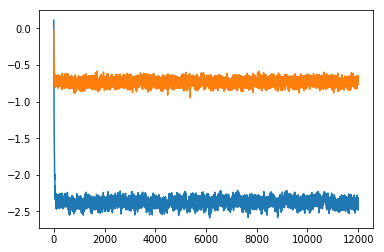

['dist', 'at_campus', 'os_mm', 'G_ratings', 'G_price']
[-2.37536002 -0.73383618]
[-2.4584061  -0.70720137]
[0.96621954 1.03766228]


In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(b_stor)
plt.show()
print(['dist','at_campus','os_mm','G_ratings','G_price'])
print(np.mean(b_stor[3000:,:],axis= 0))
print(b_true)
print(np.mean(b_stor[3000:,:], axis = 0) / b_true)

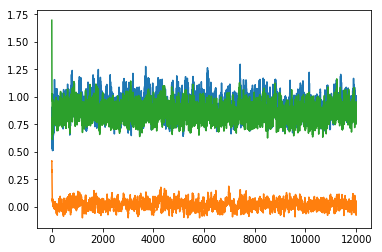

[0.90395907 0.01981472 0.85166764]
[ 0.94973965 -0.00853747  0.86934546]
[ 0.9517967  -2.32091284  0.97966538]


In [32]:
%matplotlib inline
plt.plot(W_stor)
plt.show()
print(np.mean(W_stor[3000:,:],axis= 0))
print(B_true[np.triu_indices(2)])
print(np.mean(W_stor[3000:,:],axis= 0) / B_true[np.triu_indices(2)])

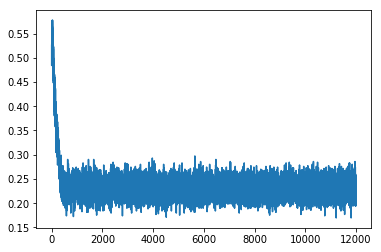

1.2800000000000007


In [33]:
%matplotlib inline
plt.plot(acc_stor)
plt.show()
print(rho)
# The acceptance rate went totally haywire which is not good. 

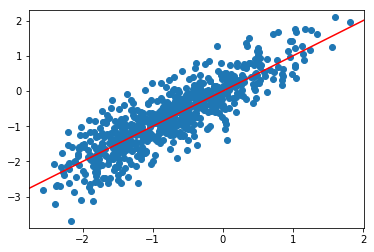

In [38]:
# Comparing individual estimates to the true estimates: 
var = 1

beta_m = np.mean(beta_stor[:,var,3000:], axis=1)
x=np.linspace(-100,100,101) 

beta_t = coeff[:,var]
plt.scatter(beta_m,beta_t)
plt.plot(x,x,'r')
plt.xlim(beta_m.min()-0.2,beta_m.max()+0.2)
plt.ylim(beta_t.min()-0.2,beta_t.max()+0.2)
plt.show()


<IPython.core.display.Javascript object>


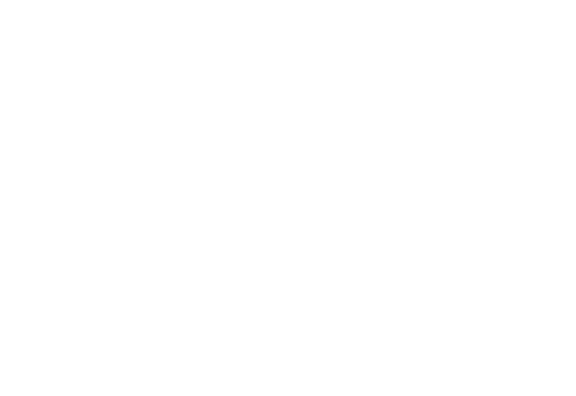

ValueError: x and y must be the same size

<IPython.core.display.Javascript object>


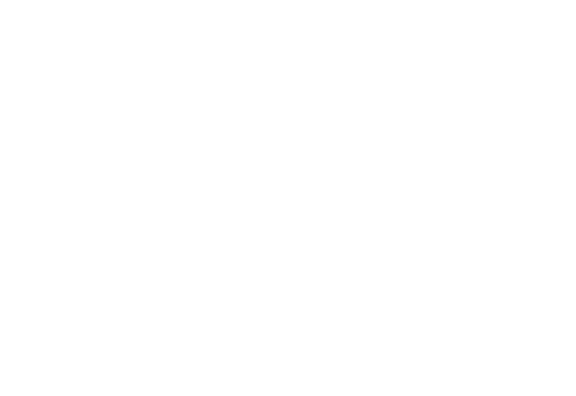

In [114]:
%matplotlib notebook
#plt.scatter(range(1000),np.mean(beta_stor[:,0,:], axis =1))
plt.scatter(range(20),np.mean(beta_stor[0:10,0,:], axis =1))
plt.scatter(range(20),np.mean(beta_stor[0:10,0,:], axis =1))
#plt.scatter(range(20),np.mean(beta_stor[0:20,2,:], axis =1))
plt.show()
#plt.scatter(range(1000),np.mean(beta_stor[:,2,:], axis =1))

#plt.plot(beta_stor[:,1,:])
#plt.plot(beta_stor[:,2,:])
#np.mean(beta_stor[:,0,:], axis =1).shape

0.030429641891878023


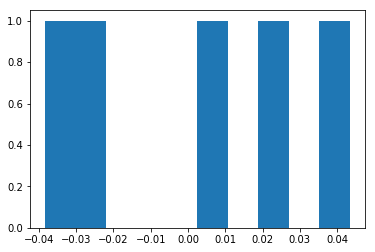

In [649]:
## Plotting the distribution of parameters from beta_stor
var  = 0
print(np.mean(np.mean(beta_stor, axis=2 )[:,var], axis=0))
['dist', 'at_campus', 'os_mm', 'G_ratings', 'G_price']

plt.hist(np.mean(beta_stor, axis= 0)[:,var], bins=10)
plt.show()

In [645]:
## Plotting the willingsness to travel space. 
WTT = beta_stor[:,0,:] / beta_stor[:,2,:]
np.mean(WTT, axis = 1)
# Be careful when plotting this as it might lead to a crash. 
#plt.hist(np.mean(WTT[695,:], axis=1),bins=100)

array([-2.65640846e-01,  1.35149540e-01,  8.45251851e-01, -7.36894271e+00,
        5.66709142e-01,  3.97251091e-01,  5.31390643e-02,  3.20762680e-01,
        6.20660635e-03,  6.88957990e-01, -2.60922058e-01,  1.00510862e+00,
        4.71599933e-04, -4.86618137e-01,  1.29938795e-01, -4.03919519e-02,
        2.45888492e-03,  1.04747415e+00, -1.22313292e-02,  1.18174470e+01,
        9.60448455e-01,  1.36854750e+01,  4.12655083e+00, -7.61522575e-02,
       -2.01208400e+00, -3.64436291e+00,  3.61645896e+00, -5.47061678e-02,
       -1.07198426e+00,  1.42293537e-01,  1.35645891e+00,  3.81105145e-02,
       -9.92358500e-01,  1.01538301e+00,  6.10689129e-02,  3.16593978e-02,
       -5.45360588e+00,  6.87844473e-01, -3.80354247e+01, -1.41184005e+00,
       -9.67981306e-01,  7.99951175e-01,  1.60616122e+00, -1.51855750e+00,
        1.38689583e-01,  3.13892697e-01, -1.03104273e+00,  9.19238570e-02,
        3.14789355e-01,  8.01268352e-02,  3.81412503e-01,  3.77902948e-03,
       -1.24378484e+00,  

### Building a sampler that allows for constants: 
 - It will unfortunately slow down the procedure because of the extra M-H layer
 - by a factor of 2 

array([-0.07512669,  0.06864103, -1.16653159, -0.92148773,  0.5241297 ,
        1.58282785,  0.55929451,  0.28266047,  1.00397809])

In [546]:
X.shape

(696, 5, 10, 14)

In [57]:
# Random alternative specific coefficients: 
N = 1000
J = 12  # alternatives
T = 10 # Choice situations
extras = 0
K_b = 2  + extras# variables
K_a = J - 1
K = K_b + K_a
mean = np.zeros((N,T,J,K_b- extras))
variance = np.identity(K_b- extras)*2 
X_b = normal(mean, 1)
X_a = np.zeros((N,T,J,K_a))

for i in range(K_a):
    print(i+1)
    X_a[:,:,i+1,i] = 1
X = np.concatenate((X_a,X_b),axis=3)

X.shape # N*T*J*K

## Simulating som mixed logit data:
# U = deterministic part + random part


# Random coefficients
# Coefficients drawn from a normal: 
# Priors
b = normal(0,1,K_b)
b_true_coeff = b


B = np.identity(K_b)*1 #+ np.diag((2,1))
B[0,0] = 2


U = np.zeros((N,T,J))
#U_t = U

# Beta coefficients
#coeff=np.random.multivariate_normal(b,B, size = N) 
coeff=rng.multivariate_normal(b,B, size = N) 

# alpha 
alpha = normal(0,1,K_a)
a_true = alpha





b_true = np.mean(coeff, axis = 0)
B_true=np.cov(coeff,rowvar=False)

# This step attempts to recreate the no identification problems that i'm experiencing
var = np.zeros(J)
var[0] = 1
#var[0] = 1

var = np.repeat(var[None,:],N,axis=0)
var = np.repeat(var[:,None,:],T,axis=1)

print(var[:,:,:,None].shape, X.shape)
#X = np.concatenate((X,var[:,:,:,None]),axis=3)





print(b_true)
print(b)
print(B_true)
gumb = rng.gumbel(size = (N,T,J))
print(gumb.shape)
for n in range(N): 
    for t in range(T):
        U_n=X[n,t,:].dot(np.concatenate((alpha,coeff[n,:])).T) + gumb[n,t,:] 
        U[n,t,:] = U_n
        
        #U_n=X_b[n,t,:].dot(coeff[n,:]).T + gumb[n,t,:]
        #U_t[n,t,:] = U_n


Y = np.argmax(U,axis = 2)
# Making a baseline category: U < 0 
#base_choices=np.argwhere(np.max(U,axis=2) < 0)
#Y[base_choices] = J

unique, counts = np.unique(Y, return_counts=True)
counts

1
2
3
4
5
6
7
8
9
10
11
(1000, 10, 12, 1) (1000, 10, 12, 13)
[-0.36656382  0.78760937]
[-0.36000233  0.78049768]
[[1.84025444 0.0558201 ]
 [0.0558201  1.03195625]]
(1000, 10, 12)


array([ 728,  236,  736, 1425,  662,  495,  788,  636,  710, 1519, 1268,
        797])

In [58]:
var[0,0,:]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [59]:
X.shape # N*T*J*K I will reshape this into a NTJ*1
X_t = X.reshape((N*T*J,K))
user = np.repeat(range(N),T*J) # I make an index that is supposed to look as if a user index existed
Y_t = Y.reshape(N*T)
Y_tt = Y_t.repeat(J)
#beta_N.shape
Y_tt 
index=np.tile(range(J),N*T)
y_index=np.where(np.equal(Y_tt,index).astype(int))[0]

mask = np.ones(index.size, dtype=bool)
mask[y_index] = 0
y_nindex = np.where(mask)[0]
y_nindex

np.array([user,index]).T
list_users=user[y_index]
users=list(collections.Counter(user).values())
NT = N*T

X_t=X_t.astype(float)
count_users = np.cumsum(np.unique(list_users, return_counts=True)[1])
count_users

array([   10,    20,    30,    40,    50,    60,    70,    80,    90,
         100,   110,   120,   130,   140,   150,   160,   170,   180,
         190,   200,   210,   220,   230,   240,   250,   260,   270,
         280,   290,   300,   310,   320,   330,   340,   350,   360,
         370,   380,   390,   400,   410,   420,   430,   440,   450,
         460,   470,   480,   490,   500,   510,   520,   530,   540,
         550,   560,   570,   580,   590,   600,   610,   620,   630,
         640,   650,   660,   670,   680,   690,   700,   710,   720,
         730,   740,   750,   760,   770,   780,   790,   800,   810,
         820,   830,   840,   850,   860,   870,   880,   890,   900,
         910,   920,   930,   940,   950,   960,   970,   980,   990,
        1000,  1010,  1020,  1030,  1040,  1050,  1060,  1070,  1080,
        1090,  1100,  1110,  1120,  1130,  1140,  1150,  1160,  1170,
        1180,  1190,  1200,  1210,  1220,  1230,  1240,  1250,  1260,
        1270,  1280,

In [60]:
## Building a beta draw

from numpy.random import multivariate_normal as MVNrnd

def b_posterior(b_mean, W):
    def normal_draw(mean, cov, check_valid = "raise"):
        return MVNrnd(mean,cov)
    return normal_draw(b_mean,W)

In [61]:
def posterior_W_v2(b, beta_N):
    # Beta_N: N*K matrix
    N = beta_N.shape[0]
    K = beta_N.shape[1]

    beta = beta_N - b
    S_bar = np.einsum('ni,nj->ij',beta, beta)/N
    dof = K+N
    scale_matrix = (K*np.identity(K)+N*S_bar)/(K+N)

    # step 1
    phi=normal(0,1, dof)
    # step 2
    L = np.linalg.cholesky(np.linalg.inv(scale_matrix))

    vector=phi[:,None,None] * L
    R=np.einsum('tni,tnj->ij',vector, vector)/dof
    
    return np.linalg.inv(R)


In [62]:
beta_N = np.ones((696,K))*0.01

In [63]:
A_u, A_c=np.unique(list_users,return_counts = True)
def reshape(A_u,A_c):
    k = 0
    t = 0
    put_list = []
    set_list = []
    p= np.ones((A_u.size,np.max(A_c)))
    for i in range(A_u.size):
        for j in range(np.max(A_c)):
            if j <= A_c[i]-1:
                #p[i,j] = B[k]
                set_list.append(t)
                k += 1
            t += 1
    return set_list, np.max(A_c)

index, t_max = reshape(A_u,A_c)

def density_pdf(mean, cov, beta):
    return scipy.stats.multivariate_normal(mean, cov).pdf(beta)

# a potential speed up might be possible by dividing data into two parts and then do
# the relatively simple calculations of alpha on a smaller set. 
def softmax_likelihood_v5(data, y_index, y_nindex, beta, users, N, NT, J, t_max, index):
    # construct N*T*K betas by repeating betas
    betas = np.repeat(beta, users, axis = 0)
    mu = np.exp(np.einsum('nj,nj->n',data,betas))
    denom = mu[y_index] # NT 
        
    # I'm worried the num is not returning correct values.
    num = np.sum(mu[y_nindex].reshape(NT,J-1),axis=1) + denom # NT*J -> NT
    sm_scores = denom / num
    # alternative approach: 
    test = np.ones(N*t_max)
    np.put(test, index, sm_scores)
    test = test.reshape((N,t_max))
    test = np.prod(test, axis= 1)
    return test

%timeit test1 = softmax_likelihood_v5(X_t, y_index, y_nindex, beta_N, users, N, NT, J, t_max, index)

ValueError: operands could not be broadcast together with shape (696,) (1000,)

In [64]:
W = np.identity(K_b)
rho = 0.44
beta_N = np.ones((N,K_b))*0.01

In [65]:
beta_N.shape
b.shape

(2,)

In [66]:
def metropolis_step_beta(data, y_index, y_nindex, alpha_0, beta_0, b, W, rho, users, N, NT, J, t_max, index, F0=None, a_upd=0):
        
    K=beta_0.shape[1]
    N=beta_0.shape[0]
    L = np.linalg.cholesky(W) # Cholesky factor of W
    eta = normal(0,1,(N,K)) #stacked vector of standard normal draws
    #print(eta.shape)
    #print(beta_N.shape)
    
    # This is a bit slow but I cannot find a better way to do it
    alpha = np.repeat(alpha_0[None,:], N,axis=0)
    
    # trial value:
    beta_1_proposal = beta_0 + rho*eta.dot(L)

    # Draw a standard uniform variable: 
    threshold = np.random.uniform(0,1,N)

    # merge coefficients together
    ab1_proposal = np.concatenate((alpha, beta_1_proposal),axis=1)
    ab0 = np.concatenate((alpha, beta_0),axis=1)
    
    # Calculate ratio:
    #data, y_index, y_nindex, beta, users, N, NT, J, t_max, index
    F1 = softmax_likelihood_v5(data, y_index, y_nindex, ab1_proposal, users, N, NT,J, t_max, index)*density_pdf(b, W, beta_1_proposal)
    if a_upd == 1:
        F0 = softmax_likelihood_v5(data, y_index, y_nindex, ab0, users, N, NT,J, t_max, index)*density_pdf(b, W, beta_0)
    F = F1/F0
    
    # accept/reject
    
    cond = np.where(threshold<F,1,0)#beta_0[],beta_1_proposal[:])
    #acc_rate= np.sum(cond) / len(cond)
    F_next = np.where(cond==1,F1,F0)

    acc_rate= np.sum(cond) / cond.size

    beta_1 = np.array([ b1 if c == 1 else b0 for b1,b0,c in zip(beta_1_proposal, beta_0, cond) ])
    
    return beta_1, acc_rate, F_next

%timeit metropolis_step_beta(X_t, y_index, y_nindex, alpha, beta_N, b, W, rho, users, N, NT, J, t_max, index, None, 1)

38.1 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [67]:
def metropolis_step_alpha(data, y_index, y_nindex, alpha_0, beta_0, rho, users, N, NT, J, t_max, index, F0=None):
    K=alpha_0.shape[0]
    N=beta_0.shape[0]
    #L = np.linalg.cholesky(W) # Cholesky factor of W

    eta = normal(0,1,K) #stacked vector of standard normal draws
    #print(eta.shape)
    #print(beta_N.shape)
    
    # trial value:
    alpha_1p = alpha_0 + rho*eta

    
    # This is a bit slow but I cannot find a better way to do it
    alpha = np.repeat(alpha_0[None,:], N,axis=0)
    alpha_1_proposal = np.repeat(alpha_1p[None,:], N,axis=0)

    # Draw a standard uniform variable: 
    threshold = np.random.uniform(0,1)
    
    # stacking coefficients together:
    
    ab1_proposal = np.concatenate((alpha_1_proposal, beta_0),axis=1)
    ab0 = np.concatenate((alpha, beta_0), axis=1)
    
    
    # Calculate ratio:
    F1 = softmax_likelihood_v5(data, y_index, y_nindex, ab1_proposal, users, N, NT, J, t_max, index)
    #if F0 is None:
    F0 = softmax_likelihood_v5(data, y_index, y_nindex, ab0, users, N, NT, J, t_max, index)
    
    F = np.prod(F1/F0)
    
    # accept/reject
    
    cond = np.where(threshold<F,1,0)#beta_0[],beta_1_proposal[:])
    #acc_rate= np.sum(cond) / len(cond)
    #F_next = F1 if cond == 1 else F0
    acc_rate= np.sum(cond) / cond.size

    alpha_1 = np.array(alpha_1p if cond == 1 else alpha_0)
    return alpha_1, acc_rate, cond

metropolis_step_alpha(X_t, y_index, y_nindex, alpha, beta_N, rho, users, N, NT, J, t_max, index)[0]

array([-1.47665897, -0.01268428,  0.87800642, -0.11449945, -0.51567998,
        0.03768933, -0.28280583, -0.12536657,  0.8912959 ,  0.66079362,
        0.07782057])

In [51]:
from  tqdm import tqdm
## Building a sampler: 
reps = 3000

#N = df.user.nunique()
#K = X_t.shape[1]
#J = df.c_index_h.nunique()

trim = 1
#starting values:
b = np.zeros(K_b)
alpha = np.random.random(K_a)
#alpha = a_true
#b = b_stor[-1,:]
#b = b_true
W = np.identity(K_b)*1 + 0.5 #np.array([[2,1,1],[1,2,1],[1,1,2]])*100
W[0,0] = 1


#W = B
#W[np.triu_indices(5)]=W_stor[-1,:]
#W[np.tril_indices(5)]=W_stor[-1,:]


beta_N = np.random.multivariate_normal(b, W, size = N)

#beta_N = beta_stor[:,:,-1]


# 
acc_rate_g = 0.3
rho_b = .5
rho_a = 0.1
F_a, F_b, a_upd = None, None, 1

# Disabling parts of the sampler
#beta_N = coeff
#b = b_true
#W = B
#beta_N = coeff
# Sampling:
b_stor = np.zeros((int(reps/trim),K_b))
a_stor = np.zeros((int(reps/trim),K_a))
W_stor = np.zeros((int(reps/trim),sum(range(K_b+1))))
beta_stor = np.zeros((N,K_b,int(reps/trim)))
alpha_stor = np.zeros((K_a,int(reps/trim)))
acc_stor = np.zeros((2,int(reps/trim)))

for t in tqdm_notebook(range(reps)):
    
    #print(beta_N.shape)
    b_mean = np.mean(beta_N, axis=0)
    #print(b_mean.shape)
    
    b = b_posterior(b_mean, W/N)
    #print(b)
    
    W = posterior_W_v2(b, beta_N)
    #print(W)
    beta_N, acc_rate_b, F_b = metropolis_step_beta(X_t, y_index, y_nindex, alpha, beta_N, b, W, rho_b, users, N,NT, J,t_max, index, F_b, a_upd)
    
    alpha, acc_rate_a, a_upd = metropolis_step_alpha(X_t, y_index, y_nindex, alpha, beta_N, rho_a, users, N, NT, J, t_max, index, F_a)
    
    

    
    # Storing the values
    if t % trim == 0:
        b_stor[int(t/trim)] = b
        W_stor[int(t/trim)] = W[np.triu_indices(K_b)]
        beta_stor[:,:,int(t/trim)] = beta_N
        alpha_stor[:,int(t/trim)] = alpha
        acc_stor[:,int(t/trim)] = acc_rate_b, acc_rate_a


    # Updating the acc_rate
    if acc_rate_b < acc_rate_g:
        rho_b = rho_b - 0.02 #(acc_rate - acc_rate_g)
    if acc_rate_b > acc_rate_g:
        rho_b = rho_b + 0.02 #(acc_rate - acc_rate_g)

    # updating after 100 iterations:
    if t % 100 == 0: 
        eva = np.mean(acc_stor[1,t-100:t])
        print(eva, rho_a)
        if eva < acc_rate_g:
            rho_a = rho_a - 0.01#*(eva - acc_rate_g)/acc_rate_g
        if eva > acc_rate_g:
            rho_a = rho_a + 0.01#*(eva - acc_rate_g)/acc_rate_g #(acc_rate - acc_rate_g)
        

    #print(beta_N[n,:])

        

    

HBox(children=(IntProgress(value=0, max=3000), HTML(value='')))

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan 0.1
0.39 0.1
0.09 0.11
0.01 0.1
0.0 0.09000000000000001
0.02 0.08000000000000002
0.03 0.07000000000000002
0.04 0.06000000000000002
0.12 0.05000000000000002
0.17 0.040000000000000015
0.2 0.030000000000000013
0.48 0.02000000000000001
0.22 0.030000000000000013
0.46 0.02000000000000001
0.32 0.030000000000000013
0.22 0.040000000000000015
0.32 0.030000000000000013
0.12 0.040000000000000015
0.28 0.030000000000000013
0.46 0.02000000000000001
0.3 0.030000000000000013
0.26 0.030000000000000013
0.42 0.02000000000000001
0.24 0.030000000000000013
0.4 0.02000000000000001
0.29 0.030000000000000013
0.44 0.02000000000000001
0.27 0.030000000000000013
0.42 0.02000000000000001
0.24 0.030000000000000013



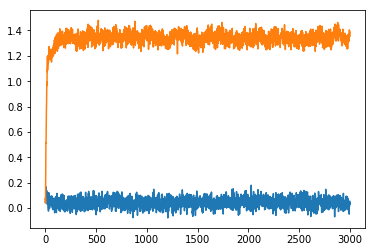

['dist', 'at_campus', 'os_mm', 'G_ratings', 'G_price']
[0.0434053  1.34032587]
[0.0499944  1.33404145]
[0.86820316 1.00471082]


In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(b_stor)
plt.show()
print(['dist','at_campus','os_mm','G_ratings','G_price'])
print(np.mean(b_stor[1000:,:],axis= 0))
print(b_true)
print(np.mean(b_stor[1000:,:], axis = 0) / b_true)

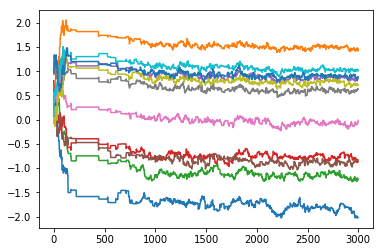

[-1.77458594  1.51091454 -1.12942566 -0.76144043  0.88195253 -0.86219487
 -0.0436396   0.61371995  0.786375    1.05851884  0.91666967]
[-1.76877815  1.57527355 -1.14922432 -0.78662327  0.9727088  -0.70311179
 -0.09676133  0.65593433  0.76764073  1.08184173  0.9067602 ]


In [53]:
plt.plot(alpha_stor.T)
plt.show()
print(np.mean(alpha_stor[:,1000:],axis= 1))
print(a_true)

0.6900000000000005

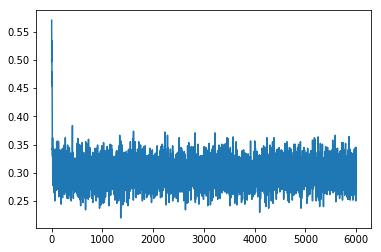

In [618]:
plt.plot(acc_stor[0,:].T)
rho_a

# Simulation study: 

In [114]:
from  tqdm import tqdm
## Building a sampler: 
reps = 12000
n_chains = 3
#N = df.user.nunique()
#K = X_t.shape[1]
#J = df.c_index_h.nunique()

trim = 1
#starting values:
b_c = np.zeros((n_chains, K_b))

b_start = [10,0,-10]
for i in range(n_chains):
    b_c[i,:] = np.ones(K_b)*b_start[i]

alpha_c = np.zeros((n_chains,K_a))
alpha_start = [10,0,-10]
for i in range(n_chains):
    alpha_c[i,:] = np.ones(K_a)*alpha_start[i]
#alpha = a_true
#b = b_stor[-1,:]
#b = b_true

W_start = [10,5,1]
W_c = np.zeros((n_chains,K_b,K_b))  #np.array([[2,1,1],[1,2,1],[1,1,2]])*100

for i in range(n_chains):
    W_c[i,:,:] = np.identity(K_b)*W_start[i]

#W = B
#W[np.triu_indices(5)]=W_stor[-1,:]
#W[np.tril_indices(5)]=W_stor[-1,:]

beta_N_c = np.zeros((n_chains,N,K_b))
for i in range(n_chains): 
    beta_N_c[i,:,:] = np.random.multivariate_normal(b_c[i,:], W_c[i,:,:], size = N)


#beta_N = beta_stor[:,:,-1]


# 
acc_rate_g = 0.3
rho_b = .5
rho_a = 0.1
F_a, F_b, a_upd = None, None, 1

# Disabling parts of the sampler
#beta_N = coeff
#b = b_true
#W = B
#beta_N = coeff
# Sampling:
b_stor = np.zeros((n_chains,int(reps/trim)+1,K_b))
W_stor = np.zeros((n_chains,int(reps/trim)+1,sum(range(K_b+1))))
beta_stor = np.zeros((n_chains,N,K_b,int(reps/trim)+1))
alpha_stor = np.zeros((n_chains,K_a,int(reps/trim)+1))
acc_stor = np.zeros((n_chains,2,int(reps/trim)+1))

for i in range(n_chains):
    beta_N = beta_N_c[i,:,:]
    b = b_c[i,:]
    W = W_c[i,:,:]
    alpha = alpha_c[i,:]
    
    beta_stor[i,:,:,0] = beta_N
    b_stor[i,0,:] = b
    W_stor[i,0,:] = W[np.triu_indices(K_b)]
    alpha_stor[i,:,0] = alpha
    
    
    for t in tqdm_notebook(range(reps)):

        #print(beta_N.shape)
        b_mean = np.mean(beta_N, axis=0)
        #print(b_mean.shape)

        b = b_posterior(b_mean, W/N)
        #print(b)

        W = posterior_W_v2(b, beta_N)
        #print(W)
        beta_N, acc_rate_b, F_b = metropolis_step_beta(X_t, y_index, y_nindex, alpha, beta_N, b, W, rho_b, users, N,NT, J,t_max, index, F_b, a_upd)

        alpha, acc_rate_a, a_upd = metropolis_step_alpha(X_t, y_index, y_nindex, alpha, beta_N, rho_a, users, N, NT, J, t_max, index, F_a)




        # Storing the values
        if t % trim == 0:
            b_stor[i,int(t/trim)+1] = b
            W_stor[i,int(t/trim)+1] = W[np.triu_indices(K_b)]
            beta_stor[i,:,:,int(t/trim)+1] = beta_N
            alpha_stor[i,:,int(t/trim)+1] = alpha
            acc_stor[i,:,int(t/trim)+1] = acc_rate_b, acc_rate_a


        # Updating the acc_rate
        if acc_rate_b < acc_rate_g:
            rho_b = rho_b - 0.02 #(acc_rate - acc_rate_g)
        if acc_rate_b > acc_rate_g:
            rho_b = rho_b + 0.02 #(acc_rate - acc_rate_g)

        # updating after 100 iterations:
        if t % 100 == 0: 
            eva = np.mean(acc_stor[i,1,t-100:t])
            print(eva, rho_a)
            if eva < acc_rate_g:
                rho_a = rho_a - 0.005#*(eva - acc_rate_g)/acc_rate_g
            if eva > acc_rate_g:
                rho_a = rho_a + 0.005#*(eva - acc_rate_g)/acc_rate_g #(acc_rate - acc_rate_g)
        

    #print(beta_N[n,:])

        

    

HBox(children=(IntProgress(value=0, max=12000), HTML(value='')))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan 0.1
0.3 0.1
0.22 0.1
0.29 0.095
0.09 0.09
0.22 0.08499999999999999
0.24 0.07999999999999999
0.18 0.07499999999999998
0.27 0.06999999999999998
0.26 0.06499999999999997
0.23 0.05999999999999998
0.19 0.05499999999999998
0.27 0.04999999999999998
0.28 0.044999999999999984
0.41 0.03999999999999999
0.29 0.044999999999999984
0.41 0.03999999999999999
0.32 0.044999999999999984
0.33 0.04999999999999998
0.33 0.05499999999999998
0.26 0.05999999999999998
0.3 0.05499999999999998
0.26 0.05499999999999998
0.19 0.04999999999999998
0.28 0.044999999999999984
0.27 0.03999999999999999
0.24 0.03499999999999999
0.26 0.02999999999999999
0.31 0.024999999999999988
0.21 0.02999999999999999
0.36 0.024999999999999988
0.21 0.02999999999999999
0.33 0.024999999999999988
0.26 0.02999999999999999
0.25 0.024999999999999988
0.47 0.019999999999999987
0.36 0.024999999999999988
0.21 0.02999999999999999
0.3 0.024999999999999988
0.31 0.024999999999999988
0.17 0.02999999999999999
0.37 0.024999999999999988
0.25 0.02999999999

HBox(children=(IntProgress(value=0, max=12000), HTML(value='')))

nan 0.024999999999999988
0.39 0.024999999999999988
0.42 0.02999999999999999
0.31 0.03499999999999999
0.21 0.03999999999999999
0.26 0.03499999999999999
0.24 0.02999999999999999
0.32 0.024999999999999988
0.24 0.02999999999999999
0.33 0.024999999999999988
0.32 0.02999999999999999
0.26 0.03499999999999999
0.21 0.02999999999999999
0.4 0.024999999999999988
0.25 0.02999999999999999
0.35 0.024999999999999988
0.3 0.02999999999999999
0.27 0.02999999999999999
0.38 0.024999999999999988
0.32 0.02999999999999999
0.18 0.03499999999999999
0.28 0.02999999999999999
0.37 0.024999999999999988
0.24 0.02999999999999999
0.3 0.024999999999999988
0.3 0.024999999999999988
0.3 0.024999999999999988
0.33 0.024999999999999988
0.26 0.02999999999999999
0.41 0.024999999999999988
0.2 0.02999999999999999
0.34 0.024999999999999988
0.3 0.02999999999999999
0.3 0.02999999999999999
0.16 0.02999999999999999
0.29 0.024999999999999988
0.37 0.019999999999999987
0.37 0.024999999999999988
0.25 0.02999999999999999
0.36 0.0249999999

HBox(children=(IntProgress(value=0, max=12000), HTML(value='')))

nan 0.02999999999999999
0.54 0.02999999999999999
0.44 0.03499999999999999
0.53 0.03999999999999999
0.52 0.044999999999999984
0.5 0.04999999999999998
0.53 0.05499999999999998
0.44 0.05999999999999998
0.43 0.06499999999999997
0.5 0.06999999999999998
0.43 0.07499999999999998
0.4 0.07999999999999999
0.48 0.08499999999999999
0.35 0.09
0.26 0.095
0.2 0.09
0.15 0.08499999999999999
0.12 0.07999999999999999
0.11 0.07499999999999998
0.06 0.06999999999999998
0.05 0.06499999999999997
0.05 0.05999999999999998
0.05 0.05499999999999998
0.04 0.04999999999999998
0.1 0.044999999999999984
0.16 0.03999999999999999
0.19 0.03499999999999999
0.3 0.02999999999999999
0.32 0.02999999999999999
0.22 0.03499999999999999
0.22 0.02999999999999999
0.33 0.024999999999999988
0.3 0.02999999999999999
0.25 0.02999999999999999
0.32 0.024999999999999988
0.26 0.02999999999999999
0.38 0.024999999999999988
0.3 0.02999999999999999
0.24 0.02999999999999999
0.25 0.024999999999999988
0.41 0.019999999999999987
0.41 0.02499999999999

In [156]:
plot(alpha_stor[j,i,:])

NameError: name 'plot' is not defined

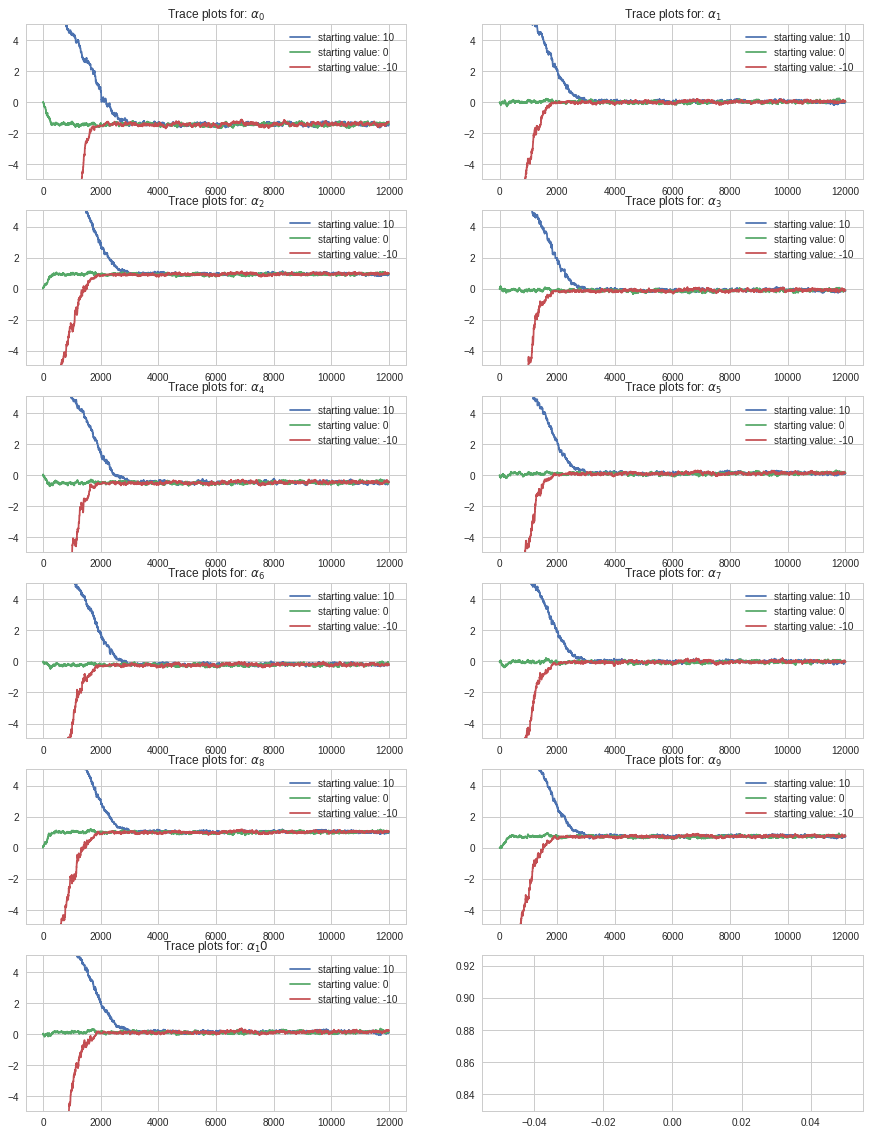

In [310]:
fig, ax = plt.subplots(6,2,figsize=(15,20))
ax = ax.flatten()
for i in range(K_a):
    for j in range(n_chains):
        label = 'starting value: ' + str(alpha_start[j])
        ax[i].plot(alpha_stor[j,i,:], label = label)
        
    plt.plot(a_true[2], color = 'Red')
    mean=alpha_stor[:,:,4000:].mean()
    ax[i].set_ylim([mean-5, mean+5])
    ax[i].legend()
    ax[i].set_title('Trace plots for: ' + r'$\alpha_{}$'.format(i))
    
#plt.ylim([-2,2])

plt.savefig('alpha_sim_study.png', bbox_inches = 'tight', dpi=150 )

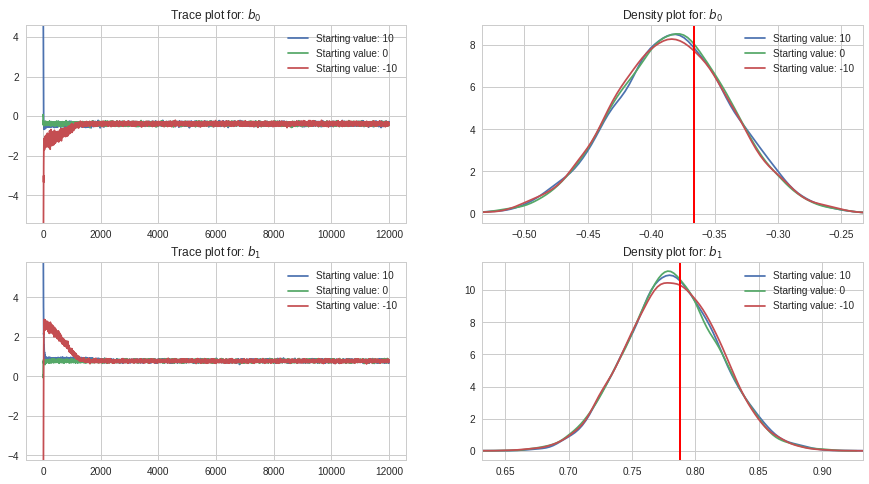

In [308]:
import seaborn as sns
sns.set_style('whitegrid')

fig, ax = plt.subplots(2,2,figsize=(15,8))
ax = ax.flatten()
for i in range(K_b):
    for j in range(n_chains):
        label = 'Starting value: ' + str(b_start[j])
        ax[i*2].plot(b_stor[j,:,i], label = label)
        sns.kdeplot(b_stor[j,4000:,i],label = label, ax = ax[i*2+1])
        ax[i*2+1].axvline(x=[b_true[i]], color = 'red')
        

        
        
    plt.plot(a_true[2], color = 'Red')
    mean=b_stor[:,4000:,i].mean()
    ax[i*2].set_ylim([mean-5, mean+5])
    ax[i*2].legend()
    ax[i*2+1].legend()
    ax[i*2+1].set_xlim([mean-0.15, mean+0.15])


    ax[i*2].set_title('Trace plot for: ' + r'$b_{}$'.format(i))
    ax[i*2+1].set_title('Density plot for: ' + r'$b_{}$'.format(i))
    
plt.savefig('b_sim_study.png', bbox_inches = 'tight', dpi = 400)
    
#plt.ylim([-2,2])

### Covariance matrix

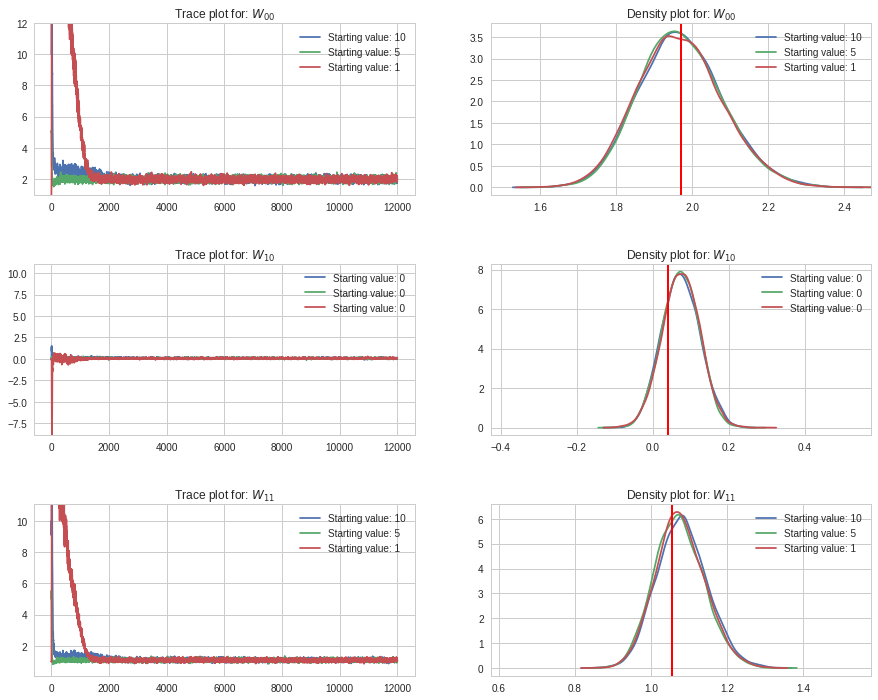

In [309]:

fig, ax = plt.subplots(3,2,figsize=(15,12))
ax = ax.flatten()

lab=[r'$W_{00}$',r'$W_{10}$',r'$W_{11}$']
for i in range(3):
    for j in range(n_chains):
        label = 'Starting value: ' + str(W_start[j])
        if i != 1:
            ax[i*2].plot(W_stor[j,:,i], label = label)
            sns.kdeplot(W_stor[j,4000:,i],label = label, ax = ax[i*2+1])
        else:
            label = 'Starting value: ' + str(0)
            ax[i*2].plot(W_stor[j,:,i], label = label)
            sns.kdeplot(W_stor[j,4000:,i],label = label, ax = ax[i*2+1])
            
        ax[i*2+1].axvline(x=W[np.triu_indices(2)][i], color = 'red')
        

        
        
    plt.plot(a_true[2], color = 'Red')
    mean=W_stor[:,4000:,i].mean()
    ax[i*2].set_ylim([mean-1, mean+10])
    ax[2].set_ylim([mean-10, mean+10])

    ax[i*2].legend()
    ax[i*2+1].legend()
    ax[i*2+1].set_xlim([mean-0.5, mean+0.5])
    

    ax[i*2].set_title('Trace plot for: ' + lab[i])
    ax[i*2+1].set_title('Density plot for: ' + lab[i])
    
plt.subplots_adjust(hspace=0.4)

    #plt.ylim([-2,2])
    
plt.savefig('W_sim_study.png', bbox_inches = 'tight', dpi=400 )

### Constructing a table with true values

In [276]:
b_stor.shape

(3, 12001, 2)

In [283]:
W_stor.shape

(3, 12001, 3)

In [290]:
a_true

array([-1.47665897, -0.01268428,  0.87800642, -0.11449945, -0.51567998,
        0.03768933, -0.28280583, -0.12536657,  0.8912959 ,  0.66079362,
        0.07782057])

In [296]:
alpha_stor.std()

2.1013439624271144

In [297]:
from pylatex import Document, LongTabu, Tabularx, Tabular, LongTable, HFill, Section, MultiColumn
from pylatex.utils import bold
def generate_longtabu():
    geometry_options = {
        "landscape": True,
        "margin": "0.5in",
        "headheight": "20pt",
        "headsep": "10pt",
        "includeheadfoot": True
    }
    doc = Section(title = "table")

    # Generate data table
    with doc.create(Tabular("l c c c, c")) as data_table:
        header_row1 = ["","Est.","True","Bias","std."]
        data_table.add_row(header_row1)#,mapper=[bold])
        
        header_row1 = ["Mean:","","","",""]
        data_table.add_row(header_row1)#,mapper=[bold])

        for i in range(b_stor.shape[-1]):
            Est = np.around(b_stor[:,4000:,i].mean(),3)
            bias = np.around(Est - b_true[i],3)
            std = np.around(b_stor[:,4000:,i].std(),3)
        
            header_row1 = ["$b_{}$".format(i),Est,np.around(b_true[i],3), bias, std]
            data_table.add_row(header_row1)#,mapper=[bold])
        

        data_table.add_empty_row()
        
        header_row1 = ["Variance:","","","",""]
        var=["$W_{00}$","$W_{10}$","$W_{11}$"]
        for i in range(W_stor.shape[-1]):
            Est = np.around(W_stor[:,4000:,i].mean(),3)
            bias = np.around(Est - W[np.triu_indices(2)][i], 3)
            std = np.around(W_stor[:,4000:,i].std(),3)
        
            header_row1 = [var[i],Est,np.around(W[np.triu_indices(2)][i], 3), bias, std]
            data_table.add_row(header_row1)#,mapper=[bold])

        header_row1 = ["ASC's:","","","",""]
        for i in range(alpha_stor.shape[1]):
            Est = np.around(alpha_stor[:,i,4000:].mean(), 3)
            bias = np.around(Est - a_true[i], 3)
            std = np.around(alpha_stor[:,i,4000:].std(), 3)

        
            header_row1 = [r"$\alpha_{}$".format(i), Est, np.around(a_true[i],3), bias,std]
            data_table.add_row(header_row1)#,mapper=[bold])

        
        

    doc.generate_tex("sim_table")

generate_longtabu()
